
# Conflicts and versions 

Conflicts are an essential part of any distributed system. 
Conflicts arise when there are two or more valid versions of the same message.

As we've seen from the previous notebooks, the network can be unreliable: there may be longer delays. But what about faults/conflicts from the clients/message producers? Moreover, a message might have multiple valid versions.  It could be that peers received two versions of the message, both being signed and valid. What version to choose? What to do when an order of the message is important? 



In [25]:
# Initialize the experiment:
from p2psimpy.config import *
import networkx as nx
from p2psimpy.services.gossip import GossipService, PullGossipService, RangedPullGossipService
from p2psimpy.simulation import BaseSimulation
from p2psimpy.services.message_producer import MessageProducer
from p2psimpy.services.connection_manager import BaseConnectionManager
import copy
import warnings
warnings.filterwarnings('ignore')
            
# We use limited messages of count 20
class LimitedMessageProducer(MessageProducer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.times = kwargs.pop('times', 20)

    def run(self):
        yield self.env.timeout(self.init_timeout)
        for _ in range(self.times):
            self.produce_transaction()
            yield self.env.timeout(self.tx_interval)
            
# Load the previous experiment configurations
exper = BaseSimulation.load_experiment(expr_dir='crash_gossip')

Locations, topology, peer_services, serv_impl = exper

saved_topology = copy.deepcopy(topology)

# Need to update some of the service implementatioin classes and message producer.
serv_impl['BaseConnectionManager'] = BaseConnectionManager
serv_impl['MessageProducer'] = MessageProducer
serv_impl['GossipService'] = GossipService

## Client generating conflicting information

Let's assign first adversary nodes, we will assign randomly: 

In [26]:
import random
import string

from p2psimpy.messages import *
from p2psimpy.consts import TEMPERED
from p2psimpy.config import Config, Func, Dist

class Transaction(BaseMessage):
    pass 

class ConflictMessageProducer(LimitedMessageProducer):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.balance = 100 
        
        
    def _generate_tx(self):        
        msg_phash = ''.join(random.choices(string.ascii_uppercase, k=20))
        diff = random.randint(1, 9)        
        data = {'hash': msg_phash, 'balance': self.balance-diff, 'diff': diff}
        tx = Transaction(self.peer, data)
        
        msg_id = '_'.join((str(self.peer.peer_id), str(self.counter)))
        msg_ttl = self.init_ttl
        return GossipMessage(self.peer, msg_id, tx, msg_ttl, 
            pre_task=self.pre_task, post_task=self.post_task)
    
    def produce_transaction(self):
        # generate new transaction
        msg = self._generate_tx()
        if self.balance - msg.data.data['diff'] < 0:
            return
        
        cons = list(self.peer.connections.keys())
        m_ix = len(cons) // 2
        for p in cons[:m_ix]:
            self.peer.send(p, msg)
            
        # Generate conflicting message as if previous transaction hasn't happened  
        msg = self._generate_tx()
        for p in cons[m_ix:]:
            self.peer.send(p, msg)
        
        self.peer.store('msg_time', str(self.peer.peer_id) +'_' + str(self.counter), self.peer.env.now)
        self.peer.store('msg_data', str(self.peer.peer_id) + '_' + str(self.counter), msg)
        self.balance -= msg.data.data['diff']
        self.counter+=1

def validate_task(msg, peer):
    # time it takes to verify the signature
    crypto_verify = Dist('norm', (1, 0.2)) 
    # time to verify the message data
    msg_verify = Dist("lognorm", (0.49512563, 4.892564, 0.0425785)) 
    
    yield peer.env.timeout(crypto_verify.get() + msg_verify.get())
    if isinstance(msg, Transaction):        
        tx = msg.data
        if tx == TEMPERED or tx['balance'] < 0:
            # You can decide what to do in this case.
            return False
    return True


class MsgConfig(Config):
    pre_task = Func(validate_task)
    
serv_impl['LimitedMessageProducer'] = ConflictMessageProducer
serv_impl['RangedPullGossipService'] = PullGossipService
peer_services['client'].service_map['LimitedMessageProducer'] = MsgConfig
peer_services

{'client': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'LimitedMessageProducer': <class '__main__.MsgConfig'>}),
 'peer': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'RandomDowntime': <class 'p2psimpy.config.DowntimeConfig'>, 'RangedPullGossipService': <class 'p2psimpy.config.GossipConfig'>})}

## Run simulation 

Let's see how adversarial agents together with crashing nodes affect the message dissemination. 

In [27]:
peer_services

{'client': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'LimitedMessageProducer': <class '__main__.MsgConfig'>}),
 'peer': PeerType(config=<class 'p2psimpy.config.PeerConfig'>, service_map={'BaseConnectionManager': None, 'RandomDowntime': <class 'p2psimpy.config.DowntimeConfig'>, 'RangedPullGossipService': <class 'p2psimpy.config.GossipConfig'>})}

In [28]:
# Init Graph
sim = BaseSimulation(Locations, topology, peer_services, serv_impl)
sim.run(5_200)

## Message analysis

Let's see how this fraction of adverserial nodes affected the network. 


In [29]:
import pandas as pd

def message_data(sim, peer_id, storage_name, client_storage_name):
    store = sim.peers[peer_id].storage[storage_name].txs
    for msg_id, tx in store.items():
        client_id, msg_num = msg_id.split('_')
        client_tx = sim.peers[int(client_id)].storage[client_storage_name].txs[msg_id]
        yield (int(msg_num), tx.data == client_tx.data)
        
def get_gossip_table(sim, storage_name, func, client_storage_name="msg_data"):
    nodes = set(sim.types_peers['peer']) | (set(sim.types_peers['leader']) if 'leader' in sim.types_peers else set())
    return pd.DataFrame({k: dict(func(sim, k, storage_name, client_storage_name)) 
                         for k in nodes}).sort_index()

    
df = get_gossip_table(sim, 'msg_data', message_data)
df

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,True,True,False,True,True,True,True,True,True,True,...,True,True,False,True,False,True,False,True,False,True
2,False,True,True,False,True,False,False,False,False,False,...,True,True,False,False,False,True,False,False,False,True
3,True,True,True,True,True,False,True,True,True,True,...,True,True,True,True,True,True,False,True,False,True
4,True,True,True,True,True,False,True,True,False,True,...,True,True,True,True,False,False,False,True,False,True
5,False,True,True,True,True,False,True,False,True,False,...,True,True,True,False,True,True,False,True,False,True
6,False,True,False,True,True,False,True,False,True,False,...,True,True,True,False,True,True,False,True,False,True
7,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
8,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False
9,False,False,False,True,True,False,False,False,False,False,...,True,False,False,False,False,True,True,True,False,True
10,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True


In [30]:
df[df==False].count()

1     11
2      5
3     10
4      6
5      1
6     13
7      6
8     12
9      9
10    13
11    10
12    15
13    14
14    16
15     1
16     4
17     7
18    10
19     9
20    14
21     3
22    17
23     7
24    18
25     2
dtype: int64

In [31]:
sim.peers[1].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'XQRJJRMVLZOSWCDDGFUI', 'balance': 97, 'diff': 3},
 '26_2': GossipMessage:Transaction:{'hash': 'TIQGIIPEHDRJPEPUOEVC', 'balance': 88, 'diff': 9},
 '26_3': GossipMessage:Transaction:{'hash': 'VKQJEELOUFGGTRWUZVPD', 'balance': 88, 'diff': 3},
 '26_4': GossipMessage:Transaction:{'hash': 'IKDSDPELFPFFTLOWXWDB', 'balance': 82, 'diff': 6},
 '26_5': GossipMessage:Transaction:{'hash': 'VKVDHJYMNPLABCLABXIM', 'balance': 75, 'diff': 7},
 '26_6': GossipMessage:Transaction:{'hash': 'ITBETUEXPVQXACRSISSV', 'balance': 72, 'diff': 4},
 '26_12': GossipMessage:Transaction:{'hash': 'OTGAYXKTGFQGBJXTDRYV', 'balance': 53, 'diff': 4},
 '26_8': GossipMessage:Transaction:{'hash': 'OSJWFBSNQXXRARDBIEFC', 'balance': 61, 'diff': 6},
 '26_7': GossipMessage:Transaction:{'hash': 'XMJBJHMUQGYVJCOKSGON', 'balance': 70, 'diff': 5},
 '26_9': GossipMessage:Transaction:{'hash': 'IBGDUWSUXVPLRNBFGTQJ', 'balance': 64, 'diff': 2},
 '26_10': GossipMessage:Transaction:{'hash': 'UIN

In [32]:
sim.peers[3].storage['msg_data'].txs

{'26_1': GossipMessage:Transaction:{'hash': 'VGERNOAXVHYPFSXDSTAI', 'balance': 95, 'diff': 5},
 '26_5': GossipMessage:Transaction:{'hash': 'FAOOBVKLHFYVRYKZLOCA', 'balance': 76, 'diff': 6},
 '26_2': GossipMessage:Transaction:{'hash': 'NLOFEADKDHSSCDCTJNWA', 'balance': 91, 'diff': 6},
 '26_3': GossipMessage:Transaction:{'hash': 'VKQJEELOUFGGTRWUZVPD', 'balance': 88, 'diff': 3},
 '26_4': GossipMessage:Transaction:{'hash': 'IKDSDPELFPFFTLOWXWDB', 'balance': 82, 'diff': 6},
 '26_6': GossipMessage:Transaction:{'hash': 'ITBETUEXPVQXACRSISSV', 'balance': 72, 'diff': 4},
 '26_7': GossipMessage:Transaction:{'hash': 'XMJBJHMUQGYVJCOKSGON', 'balance': 70, 'diff': 5},
 '26_10': GossipMessage:Transaction:{'hash': 'UINUVYHSRCZXXSVKAVGS', 'balance': 58, 'diff': 2},
 '26_9': GossipMessage:Transaction:{'hash': 'IBGDUWSUXVPLRNBFGTQJ', 'balance': 64, 'diff': 2},
 '26_8': GossipMessage:Transaction:{'hash': 'OSJWFBSNQXXRARDBIEFC', 'balance': 61, 'diff': 6},
 '26_11': GossipMessage:Transaction:{'hash': 'HZH

Peers see different versions of the same message!
This is an issue as it might violate integrity guarantees. For example, peers might have a different view on the client's balance. 

How to fix this? 
- One way to solve this is to use a (consensus algorithm)[https://en.wikipedia.org/wiki/Consensus_(computer_science)]


# Consensus algorithm


The consensus is a process that allows achieving a consistent view on a value (agreement). 
Some of the peers may fail or be unreliable, so consensus protocols must be fault-tolerant or resilient. The peers must communicate with one another and agree on a single value.

The consensus problem is fundamental in all distributed systems. One approach to generating consensus is for all processes (agents) to agree on a majority value. In this context, a majority requires at least one more than half of the available votes (where each process is given a vote). However, one or more faulty processes may skew the resultant outcome such that consensus may not be reached or reached incorrectly.



#  Exercise 

In this notebook we ask to implement a consensus service and show that all honest peers accept the same value.  
You can assume that an elected leader is never faulty. 
Here are some poissible algorithms you can consider: 
- **Majority Voting**. Fully connected network. Send votes to all nodes. Choose the value based on majority/super-majority. How many rounds/phases do you need?  
- **Majority Voting with Neighbours**. Connected network. Send votes to all neighbors. Choose the value based on majority/super-majority of your neighbors. How many rounds/phases you need for full convergence? 
- **Consensus through a lottery**. Send transactions through gossip. Everybody runs some lottery mechanism: that both takes time and chooses one or several nodes. This(these) nodes decide which version of the transaction to pick and send through gossip a decided version of transactions (block). How many rounds of lottery you need for convergence? 

**You can choose any of the above algorithm or propose your own**


In [33]:
# We implemented Majority voting in fully connected network.

import networkx as nx
from random import choice
from random import sample

# Create a fully connected network topology
def prepare_complete_topology(num_peers=25, num_clients=1, leader_num=1):    
    # Create network topology
    G = nx.complete_graph(num_peers)   
    nx.relabel_nodes(G, {k: k+1 for k in G.nodes()} ,copy=False)
    
    # Connect the client node to num_cons random peers
    client_edges = []
    num_cons=10
    for c in range(num_peers+1, num_clients+num_peers+1):
        for p in sample(list(G.nodes()), num_cons):
            client_edges.append((c,p))
    G.add_edges_from(client_edges)
    
    types_map = {k: 'peer' if k < num_peers+1 else 'client' for k in G.nodes()}
    types_map[leader_num] = 'leader'
    
    # Assign a peer type to the peers 
    nx.set_node_attributes(G, types_map , 'type')
    return G

full_topology = prepare_complete_topology(leader_num=1)
print("The client is connected to ", [n for n in full_topology.neighbors(26)])

The client is connected to  [6, 17, 1, 4, 3, 23, 14, 25, 22, 5]


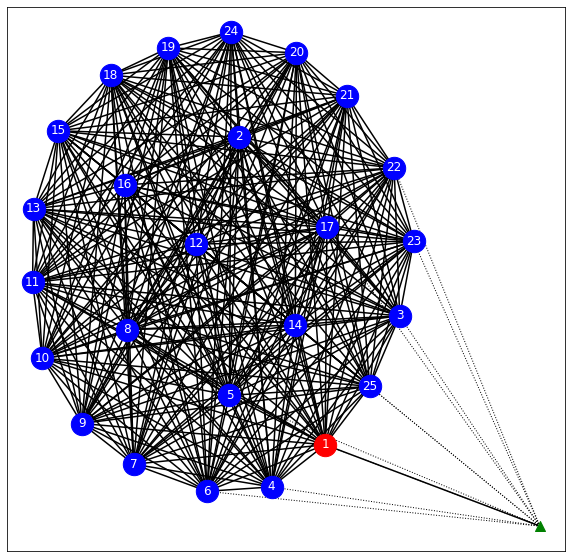

In [34]:
# Let's visualize our topology. The node in red colour is the leader in the network. And we assume that the leader does not go through periodic outages. Moreover, we connect client to 10 peers.

import matplotlib.pyplot as plt
def visualize_peer_client_network(G):
    plt.figure(figsize=(10,10))

    # Draw client/ peer network 

    master_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'peer']
    client_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'client']
    leader_nodes = [n for (n,ty) in \
        nx.get_node_attributes(G,'type').items() if ty == 'leader']
    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G, pos, nodelist=master_nodes, \
        node_color='blue', node_shape='o', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=client_nodes,  \
        node_color='green', node_shape='^', node_size=100, label=1)
    nx.draw_networkx_nodes(G, pos, nodelist=leader_nodes,  \
        node_color='red', node_shape='o', node_size=500)

    nx.draw_networkx_labels(G, pos, labels={k:k for k in master_nodes}, font_color='w')
    nx.draw_networkx_labels(G, pos, labels={k:k for k in leader_nodes}, font_color='w')

    nx.draw_networkx_edges(G, pos, edgelist=G.subgraph(master_nodes).edges(), width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=leader_nodes), width=1.5)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(nbunch=client_nodes),  style='dotted')
    
visualize_peer_client_network(full_topology)

In [35]:
# Every peer node runs two services. 
# (1) To commit and sychronize FINAL messages (or transactions) with peer nodes. 
# (2) To temporarily store pending messages received through a gossip protocol, and participate in the voting process to decide the FINAL message.

# Below is the implementation of service (1).
# We use pull-based gossip protocol for handling FINAL commited msgs and synchronize after node outages.
# The FINAL message is committed to the 'msg_data' storage.
from p2psimpy.services.base import BaseHandler, BaseRunner
from p2psimpy.messages import GossipMessage
from p2psimpy.storage.simple import Storage
from p2psimpy.services.gossip import MessageResponder
from p2psimpy.utils import Cache
from p2psimpy.config import Dist

from re import split
from copy import copy


# Special message to commit the FINAL (or agreed after majority voting) message.
class GossipMsgCommit(BaseMessage):
    def __init__(self, sender, msg_id, data, **kwargs):
        super().__init__(sender, data, **kwargs)
        self.id = msg_id

# Note that this service does not receive or handle GossipMessage from the client.
class PullGossipCommitService(PullGossipService):

    def _store_gossip_commit(self, msg):
        self.peer.store('msg_time', msg.id, self.env.now)
        self.peer.store('msg_data', msg.id, msg.data)
        
    def handle_message(self, msg):
        if type(msg) == GossipMsgCommit:
            self._store_gossip_commit(msg); 
        elif type(msg) == SyncPing:
            # Send sync pong if there more known messages
            self._peer_missing(msg)
            self._self_missing(msg)
        elif type(msg) == SyncPong:
            self._self_missing(msg)
        elif type(msg) == MsgRequest:
            # Answer with message response
            MessageResponder.handle_message(self, msg)
        elif type(msg) == MsgResponse:
            # Apply to the local storage
            for k, v in msg.data.items():
                self._store_message(v, k)

    @property
    def messages(self):
        return GossipMsgCommit, SyncPing, SyncPong, MsgRequest, MsgResponse

In [36]:
# Below is the implementation of service (2).
# Here, we implement push-based gossip protocol to disseminate GossipMessage from the client to all peers. 
# We further implement the  majority voting protocol to achieve consensus on the messages.

# VOTING PROCUDURE:
# 1. The elected leader (in our case, pre-decided peer) will periodically broadcast 'VotingRequest's with monotonically increasing 'round number' for a message.
# 2. If a peer node has seen the message then it will send 'VotingReply' with the 'round number' to the leader.
# 3. If a peer node has not seen the message then it will randomly ask another peer node to send the message (or transaction). But it will not send its vote in this 'round'.
# 4. After receiving 'VotingReply', the leader accepts the vote only if the response is for the current 'round' and the voter has not already voted.
# 5. If majority (N/2 + 1) votes have received for a particular transaction value, then the leader broadcast 'GossipMsgCommit' to commit this FINAL (or agreed) value.
# 6. If majority cannot be achieved in this round, because some peers didn't have the message, the leader starts the next round for that same message.

# Some of the messages exchanged in the voting procedure.
class VotingRequestMsg(BaseMessage):
      def __init__(self, sender, msg_id, data, **kwargs):
        super().__init__(sender, data, **kwargs)
        self.id = msg_id

class VotingReplyMsg(BaseMessage):
    def __init__(self, sender, msg_id, data, **kwargs):
        super().__init__(sender, data, **kwargs)
        self.id = msg_id

class TxRequestMsg(BaseMessage):
      def __init__(self, sender, msg_id, data, **kwargs):
        super().__init__(sender, data, **kwargs)
        self.id = msg_id

class TxReplyMsg(BaseMessage):
    def __init__(self, sender, msg_id, data, **kwargs):
        super().__init__(sender, data, **kwargs)
        self.id = msg_id

# Implementation of Gossip and Vote service.
class GossipMajorityVotingConsensus(BaseHandler, BaseRunner):
    """
    Simple gossip service to handle gossip messages and rely them to neighbors. 
    """

    def __init__(self, peer, fanout=3, total_peers=None, exclude_peers: set = None,
                 exclude_types: set = None):
        super().__init__(peer)

        self.fanout = fanout
        if exclude_peers is None:
            self.exclude_peers = set()
        else:
            self.exclude_peers = exclude_peers
        self.exclude_types = exclude_types

        self.peer.add_storage('msg_time_temp', Storage())
        self.peer.add_storage('msg_data_temp', Storage())
        self.strg = self.peer.get_storage('msg_data_temp')
        
        # Leader maintains this data structure to carry out voting.
        if self._i_am_leader():
            self.pending_msgs = {}
            self.commited_msgs = []
            self.voting_interval = 1000
            self.majority_votes = total_peers // 2 + 1
       
    def _i_am_leader(self):
        return self.peer.peer_type == "leader"
    
    def _store_message(self, msg, msg_id=None):
        if not msg_id:
            msg_id = msg.id

        self.peer.store('msg_time_temp', msg_id, self.env.now)
        self.peer.store('msg_data_temp', msg_id, msg)
        
        if self._i_am_leader():
            if msg_id not in self.pending_msgs and msg_id not in self.commited_msgs:
                self.pending_msgs[msg_id] = {'voted_count':{}, 
                                             'voted_list':[],
                                             'voted_data': {},
                                             'round': 0}


    # Simulate time delays
    def wait(self):
        yield self.env.timeout(100)

    def _handle_gossip_msg(self, msg):
        # Store message localy
        self._store_message(msg)
        if msg.ttl > 0:
            # Rely message further, modify the message
            exclude_peers = {msg.sender} | self.exclude_peers
            # Use peer gossip - it will sample self.config.fanout and exclude sender
            # If you need to exclude some peers: add it to the set
            self.peer.gossip(GossipMessage(self.peer, msg.id, msg.data, msg.ttl-1,
                                           pre_task=msg.pre_task, post_task=msg.post_task),
                             self.fanout, except_peers=exclude_peers, except_type=self.exclude_types)
            
    def _handle_tx_request(self, msg):
        msg_id = msg.id
        if msg_id in self.strg.txs:
            tx = self.strg.txs[msg_id].data
            self.peer.send(msg.sender, TxReplyMsg(self.peer, msg_id, tx))
            
    def _handle_tx_reply(self, msg):
        msg_id = msg.id
        tx = msg.data
        gossip_msg = GossipMessage(self.peer, msg_id, tx, 0)
        self.peer.store('msg_time_temp', msg_id, self.env.now)
        self.peer.store('msg_data_temp', msg_id, gossip_msg)
    
    def _handle_voting_request(self, msg):
        msg_id = msg.id
        data = msg.data 
        if msg_id in self.strg.txs:
            data['tx'] = self.strg.txs[msg_id].data
            self.peer.send(msg.sender, VotingReplyMsg(self.peer, msg_id, data))
        else:
            # randomly choose a peer node
            random_peer = None
            while random_peer == None:
                choice = random.choice(list(self.peer.connections.keys()))
                random_peer = self.peer.connections[choice].receiver
                if random_peer.peer_type == 'client':
                    random_peer = None
            self.peer.send(random_peer, TxRequestMsg(self.peer, msg_id, None))
      
    def _check_for_consensus(self, msg_id):
        msg_state = self.pending_msgs[msg_id]
        max_tx_hash = max(msg_state['voted_count'], key=msg_state['voted_count'].get)
        total_votes = msg_state['voted_count'][max_tx_hash]
        if total_votes >= self.majority_votes:
            tx = msg_state['voted_data'][max_tx_hash]
            data = GossipMessage(self.peer, msg_id, tx, 0)
            gossip_commit = GossipMsgCommit(self.peer, msg_id, data)
            del self.pending_msgs[msg_id]
            self.commited_msgs.append(msg_id)
            self.peer.broadcast(gossip_commit, except_type=self.exclude_types)
            print("Consensus for msg {} is achieved at round {}".format(msg_id, msg_state['round']))
            
        
    def _handle_voting_reply(self, msg):
        msg_id = msg.id
        if msg_id not in self.pending_msgs:
            assert msg_id in self.commited_msgs, "Message is not commited"
            return
        
        round = msg.data['round']
        msg_state = self.pending_msgs[msg_id]
        if msg_state['round'] == round and msg.sender not in msg_state['voted_list']:
            tx = msg.data['tx']
            tx_hash = tx.data['hash']
            self.pending_msgs[msg_id]['voted_list'].append(msg.sender.peer_id)
            if tx_hash not in self.pending_msgs[msg_id]['voted_count']:
                self.pending_msgs[msg_id]['voted_count'][tx_hash] = 0
                self.pending_msgs[msg_id]['voted_data'][tx_hash] = tx
            else:
                self.pending_msgs[msg_id]['voted_count'][tx_hash] += 1
            
            self._check_for_consensus(msg_id)
        
    
    def handle_message(self, msg):
        if type(msg) == GossipMessage: # This client message through initial gossip
            self._handle_gossip_msg(msg)
        elif type(msg) == TxRequestMsg: # This transaction request is sent by a peer which has not seen the earlier gossip message from the client
            self._handle_tx_request(msg)
        elif type(msg) == TxReplyMsg:
            self._handle_tx_reply(msg)
        elif type(msg) == VotingRequestMsg:
            self._handle_voting_request(msg)
        elif type(msg) == VotingReplyMsg:
            assert self._i_am_leader(), "I am not a leader"
            self._handle_voting_reply(msg)
            

    def run(self):
        while self._i_am_leader():
            yield self.env.timeout(self.voting_interval)
            # The leader initiates voting request periodically.
            for msg_id, voting_data in self.pending_msgs.items():
                voting_data['round'] += 1
                self.pending_msgs[msg_id]['round'] = voting_data['round']
                self.pending_msgs[msg_id]['voted_list'] = []
                self.pending_msgs[msg_id]['voted_count'] = {}
                self.pending_msgs[msg_id]['voted_data'] = {}
                msg_data = {'round': voting_data['round']}
                self.peer.broadcast(VotingRequestMsg(self.peer, msg_id, msg_data), except_type=self.exclude_types)
                
    @property
    def messages(self):
        return GossipMessage, VotingRequestMsg, VotingReplyMsg, TxRequestMsg, TxReplyMsg


In [37]:
import copy
peer_services_consensus = copy.deepcopy(peer_services)
serv_impl_consensus = copy.deepcopy(serv_impl)

In [38]:
from p2psimpy.services.disruption import RandomDowntime

gossip_config = peer_services['peer'].service_map['RangedPullGossipService']
peer_config = peer_services['peer'].config
downtime_config = peer_services['peer'].service_map['RandomDowntime']

# Configuration used to set the values of message producer
class MsgConfig(Config):
    pre_task = Func(validate_task)
    init_timeout = 1000 # Add some delay so that the peer network is built before starting with this message.class ClientMsgProducerConfig
    init_ttl = 1
    
# Configuration used for our voting and GossipService
class GossipVotingConfig(Config):
    exclude_types={'client',}
    fanout = 24 # (N - 1)
    total_peers = 25
    
peer_services_consensus['client'].service_map['LimitedMessageProducer'] = MsgConfig
peer_services_consensus['peer'] = PeerType(peer_config,
                                      {BaseConnectionManager: None, PullGossipCommitService: gossip_config, GossipMajorityVotingConsensus: GossipVotingConfig,
                                        RandomDowntime: downtime_config
                                      }
                                     )
peer_services_consensus['leader'] = PeerType(peer_config,
                                      {BaseConnectionManager: None, PullGossipCommitService: gossip_config, GossipMajorityVotingConsensus: GossipVotingConfig}
                                     )

In [39]:
sim1 = BaseSimulation(Locations, full_topology, peer_services_consensus, serv_impl_consensus)
sim1.run(30_200)

# Here, we see that the voting protocol takes more than 1 round to decide on the majority value. 
# This is due to peer outages and Push-based gossip protocol, which does not achieve convergence in the initial Gossip phase.

Consensus for msg 26_1 is achieved at round 2
Consensus for msg 26_10 is achieved at round 1
Consensus for msg 26_6 is achieved at round 1
Consensus for msg 26_3 is achieved at round 2
Consensus for msg 26_5 is achieved at round 2
Consensus for msg 26_2 is achieved at round 2
Consensus for msg 26_7 is achieved at round 1
Consensus for msg 26_8 is achieved at round 2
Consensus for msg 26_13 is achieved at round 1
Consensus for msg 26_11 is achieved at round 1
Consensus for msg 26_12 is achieved at round 1
Consensus for msg 26_4 is achieved at round 4
Consensus for msg 26_9 is achieved at round 3
Consensus for msg 26_16 is achieved at round 1
Consensus for msg 26_15 is achieved at round 3
Consensus for msg 26_19 is achieved at round 2
Consensus for msg 26_14 is achieved at round 3
Consensus for msg 26_20 is achieved at round 3
Consensus for msg 26_17 is achieved at round 5
Consensus for msg 26_18 is achieved at round 7


In [40]:
df = get_gossip_table(sim1, 'msg_data', message_data)
df

# So, the below table shows that all the peer nodes agreed upon the same value for all the messages.

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [41]:
df[df==True].count()

1     13
2     13
3     13
4     13
5     13
6     13
7     13
8     13
9     13
10    13
11    13
12    13
13    13
14    13
15    13
16    13
17    13
18    13
19    13
20    13
21    13
22    13
23    13
24    13
25    13
dtype: int64

In [42]:
sim1.peers[6].storage['msg_data'].txs

{'26_3': GossipMessage:Transaction:{'hash': 'ONYJDJWBHXJMZLVAGFJM', 'balance': 92, 'diff': 6},
 '26_6': GossipMessage:Transaction:{'hash': 'CLDLZDKHUTGKCQVTHKTY', 'balance': 75, 'diff': 5},
 '26_2': GossipMessage:Transaction:{'hash': 'BXFLZAOJNOEHRHBCCPVW', 'balance': 98, 'diff': 1},
 '26_10': GossipMessage:Transaction:{'hash': 'JJIFSQSVZNAORWOXQYQL', 'balance': 58, 'diff': 5},
 '26_1': GossipMessage:Transaction:{'hash': 'WOTRGYFXVOCICUTTVSMY', 'balance': 99, 'diff': 1},
 '26_5': GossipMessage:Transaction:{'hash': 'BXHWLCGMROZPARNJKVEZ', 'balance': 80, 'diff': 8},
 '26_7': GossipMessage:Transaction:{'hash': 'EDZAYXDHTMXGWDBWYXZQ', 'balance': 72, 'diff': 3},
 '26_8': GossipMessage:Transaction:{'hash': 'LPXBHLFBWJZPVEIUFJQF', 'balance': 67, 'diff': 5},
 '26_11': GossipMessage:Transaction:{'hash': 'JZFCKASAUAAUGCVFCRIO', 'balance': 49, 'diff': 9},
 '26_13': GossipMessage:Transaction:{'hash': 'NKHXREJKHIHDVPPESIVF', 'balance': 38, 'diff': 4},
 '26_12': GossipMessage:Transaction:{'hash': 'M

In [43]:
sim1.peers[1].storage['msg_data'].txs

{'26_5': GossipMessage:Transaction:{'hash': 'BXHWLCGMROZPARNJKVEZ', 'balance': 80, 'diff': 8},
 '26_1': GossipMessage:Transaction:{'hash': 'WOTRGYFXVOCICUTTVSMY', 'balance': 99, 'diff': 1},
 '26_6': GossipMessage:Transaction:{'hash': 'CLDLZDKHUTGKCQVTHKTY', 'balance': 75, 'diff': 5},
 '26_2': GossipMessage:Transaction:{'hash': 'BXFLZAOJNOEHRHBCCPVW', 'balance': 98, 'diff': 1},
 '26_3': GossipMessage:Transaction:{'hash': 'ONYJDJWBHXJMZLVAGFJM', 'balance': 92, 'diff': 6},
 '26_10': GossipMessage:Transaction:{'hash': 'JJIFSQSVZNAORWOXQYQL', 'balance': 58, 'diff': 5},
 '26_7': GossipMessage:Transaction:{'hash': 'EDZAYXDHTMXGWDBWYXZQ', 'balance': 72, 'diff': 3},
 '26_13': GossipMessage:Transaction:{'hash': 'NKHXREJKHIHDVPPESIVF', 'balance': 38, 'diff': 4},
 '26_11': GossipMessage:Transaction:{'hash': 'JZFCKASAUAAUGCVFCRIO', 'balance': 49, 'diff': 9},
 '26_12': GossipMessage:Transaction:{'hash': 'MPQJYJHKRQTBJHQLQSPU', 'balance': 42, 'diff': 7},
 '26_8': GossipMessage:Transaction:{'hash': 'L